# Churn Prediction Model
**This notebook walks through the process of building a customer churn prediction model.
The model's goal is to predict whether a customer is likely to churn (leave the service) based on various features like their credit score, geography, age, balance, and other relevant information.**

**CatBoost is used as the modeling algorithm. It's a gradient boosting library that is particularly good at handling categorical features and often provides high accuracy. Its role here is to learn the complex relationships between the input features and the target variable (churn) to make accurate predictions.**



### Install Libraries

This cell installs the `catboost` library, which is used for building the churn prediction model.

In [1]:
!pip install catboost

Access is denied.


### Load Data and Initial Exploration

This cell imports the necessary libraries for data manipulation, visualization, and model building. It then loads the `Churn_Modelling.csv` dataset and performs an initial exploration of the data, including checking the shape, data types, missing values, and statistical summary.

In [2]:
#Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
#Load the dataset
df=pd.read_csv('Churn_Modelling.csv')
#EDA & Feature Engineering
#Inspect the data
print("\033[1m-------Dataset Overview-------\033[0m")
print("\n\033[1mShape of the data: \033[0m",df.shape)
print("\n\033[1mColumn names and data types:\n\033[0m",df.info())
print("\n\033[1mPreview of the data:\033[0m\n",df.head())
print("\n\033[1mMissing Values:\n\033[0m",df.isnull().sum())
print("\n\033[1mStatistical Summary:\n\033[0m",df.describe())

-------Dataset Overview-------

Shape of the data:  (10000, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB

Column names and data types:


### Detect and Rename Target Column

This cell defines a function to automatically detect the target column (churn variable) based on common keywords. It then renames the detected target column to 'Exited' for consistency.

In [3]:
#Detect Target Variable
def detect_target_column(df):
    target_keywords = ['churn', 'target', 'label', 'status', 'exited', 'left']
    for col in df.columns:
        if any(keyword in col.lower() for keyword in target_keywords):
            return col
    return None  # if no matching column
target_col = detect_target_column(df)
if not target_col:
    raise ValueError("No churn/target column found in this dataset.")
#Renaming target variable
df.rename(columns={target_col: 'Exited'}, inplace=True)

### Drop Irrelevant Columns and Duplicates

This cell drops irrelevant columns such as 'RowNumber', 'CustomerId', and 'Surname' from the dataset as they are not useful for the churn prediction model. It also removes any duplicate rows to ensure data integrity.

In [4]:
df.drop(columns=["RowNumber", "CustomerId", "Surname"], inplace=True)
#Remove duplicated rows if any
df = df.drop_duplicates()

### Exploratory Data Analysis and Feature Engineering

This cell performs Exploratory Data Analysis (EDA) and Feature Engineering. It generates a correlation heatmap to visualize the relationships between numerical features and the target variable. It also creates count plots to visualize the distribution of churn across different categorical features like Gender and Geography. Finally, it engineers new features such as 'BalanceSalaryRatio', 'IsSeniorCitizen', 'CreditTenureRatio', and 'Geography_Gender' to potentially improve model performance.

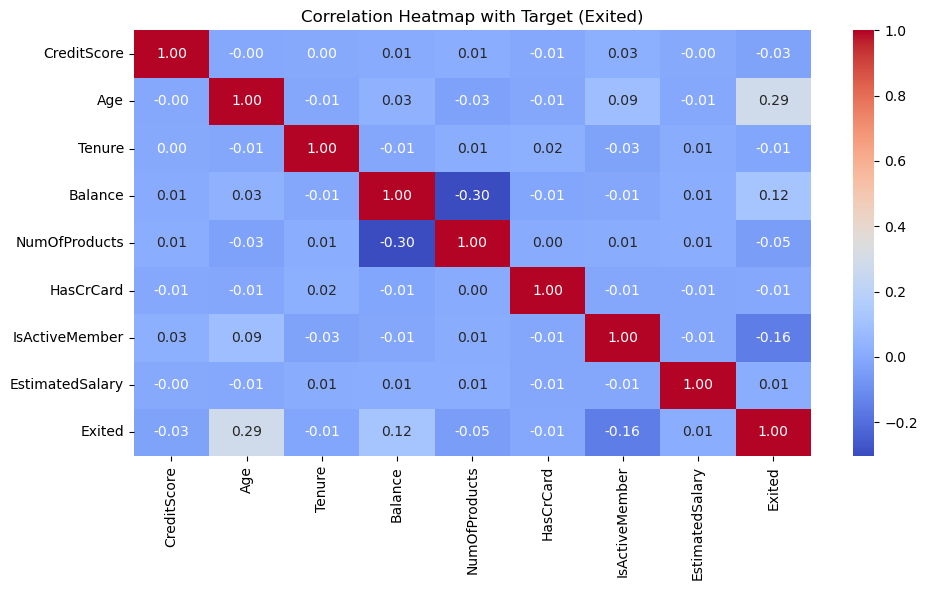

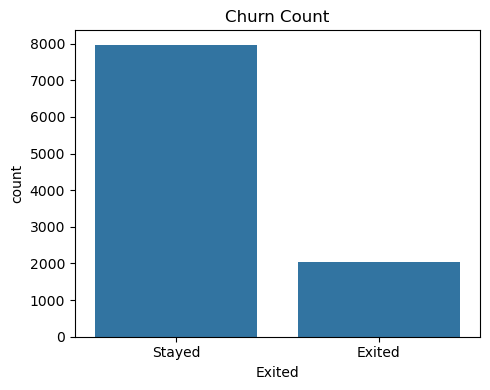

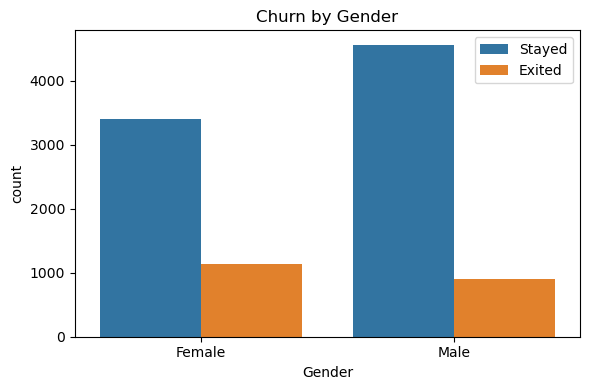

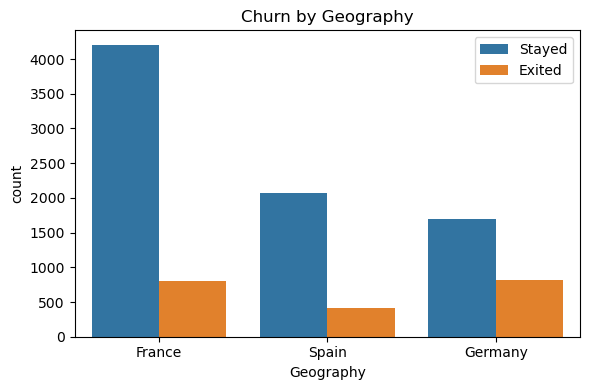

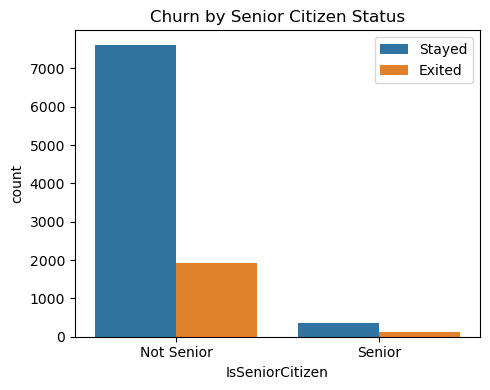

In [5]:

#EDA - Correlation Heatmap
correlation_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap with Target (Exited)")
plt.tight_layout()
plt.show()

# Bar Plots
plt.figure(figsize=(5, 4))
sns.countplot(x="Exited", data=df)
plt.title("Churn Count")
plt.xticks([0, 1], ["Stayed", "Exited"])
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="Gender", hue="Exited", data=df)
plt.title("Churn by Gender")
plt.legend(labels=["Stayed", "Exited"])
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.countplot(x="Geography", hue="Exited", data=df)
plt.title("Churn by Geography")
plt.legend(labels=["Stayed", "Exited"])
plt.tight_layout()
plt.show()

#Feature Engineering
df["BalanceSalaryRatio"] = df["Balance"] / (df["EstimatedSalary"] + 1)
df["IsSeniorCitizen"] = (df["Age"] > 60).astype(int)
df["CreditTenureRatio"] = df["CreditScore"] / (df["Tenure"] + 1)
df["Geography_Gender"] = df["Geography"] + "_" + df["Gender"]
plt.figure(figsize=(5, 4))
sns.countplot(x="IsSeniorCitizen", hue="Exited", data=df)
plt.title("Churn by Senior Citizen Status")
plt.xticks([0, 1], ["Not Senior", "Senior"])
plt.legend(labels=["Stayed", "Exited"])
plt.tight_layout()
plt.show()


### Handle Missing Values and Outliers

This cell separates the features (x) and the target variable (y). It then handles missing values in both numerical and categorical columns by imputing them with the median for numerical columns and a 'Missing' category for categorical columns. It also handles outliers in numerical columns using the Interquartile Range (IQR) method.

In [6]:
# Separate features (x) and target (y) 

x = df.drop("Exited", axis=1)
y = df["Exited"]

# Handle Missing Values 
numerical_cols = x.select_dtypes(include=['float64', 'int64']).columns
x[numerical_cols] = x[numerical_cols].fillna(x[numerical_cols].median())

# Categorical
categorical_cols = x.select_dtypes(include=['object', 'category']).columns
x[categorical_cols] = x[categorical_cols].fillna('Missing')

# Handle Outliers 
for col in numerical_cols:
    Q1 = x[col].quantile(0.25)
    Q3 = x[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    x[col] = np.where(x[col] > upper, upper, np.where(x[col] < lower, lower, x[col]))

### Preprocessing and Train-Test Split

This cell converts categorical columns to string type before splitting the data. It then splits the data into training and testing sets using `train_test_split`. Finally, it identifies the indices of the categorical features in the training set, which is required for the CatBoost model.

In [7]:

# Convert categorical columns to string or category before splitting
x[categorical_cols] = x[categorical_cols].astype(str)

# Preprocessing and Train-Test Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Identify categorical features by column index from X_train
categorical_features = [x_train.columns.get_loc(col) for col in categorical_cols]

### Build and Train CatBoost Model

This cell prepares the data for the CatBoost model by creating `Pool` objects for the training and testing sets. It then initializes the CatBoost classifier with specified parameters and trains the model on the training data, using the test data for evaluation and early stopping.

In [8]:
#Build the CatBoost Pool
from catboost import Pool, CatBoostClassifier
train_pool = Pool(data=x_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=x_test, label=y_test, cat_features=categorical_features)

#Initialize CatBoost Model
model = CatBoostClassifier(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)
#Train the Model
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=50)

0:	learn: 0.8526250	test: 0.8590000	best: 0.8590000 (0)	total: 193ms	remaining: 3m 12s
100:	learn: 0.8808750	test: 0.8625000	best: 0.8675000 (66)	total: 3.13s	remaining: 27.8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8675
bestIteration = 66

Shrink model to first 67 iterations.


### Make Predictions

This cell uses the trained CatBoost model to make predictions on the test set. It generates both the predicted class labels (`y_pred`) and the predicted probabilities (`y_pred_proba`).

In [9]:
# Make predictions
y_pred = model.predict(x_test)
y_pred_proba = model.predict_proba(x_test)[:, 1]

### Evaluate Model Performance

This cell evaluates the performance of the trained CatBoost model using various metrics such as accuracy, precision, recall, F1-score, and ROC AUC score. It also generates and prints the confusion matrix and a classification report to provide a comprehensive evaluation of the model's performance.

In [10]:
# Evaluate the Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,classification_report
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)
summary_report=classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("Confusion Matrix:\n", conf_matrix)
print("Classification_report:\n", summary_report)

Accuracy: 0.8675
Precision: 0.7645
Recall: 0.4707
F1-Score: 0.5827
ROC AUC Score: 0.8752
Confusion Matrix:
 [[1550   57]
 [ 208  185]]
Classification_report:
               precision    recall  f1-score   support

           0       0.88      0.96      0.92      1607
           1       0.76      0.47      0.58       393

    accuracy                           0.87      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.86      0.87      0.85      2000



### Install SHAP Library

This cell installs the `shap` library, which is used for explaining the output of the machine learning model.

In [ ]:
!pip install shap

### Explain Model Predictions with SHAP

This cell uses the SHAP library to explain the predictions of the CatBoost model. It creates a TreeExplainer object and calculates SHAP values for a sample of the test set. It then generates a bar plot of feature importance based on mean absolute SHAP values, a SHAP summary plot (dot plot) to visualize the distribution of SHAP values for each feature, and SHAP dependence plots for the most important features to show how individual features affect the model's output.

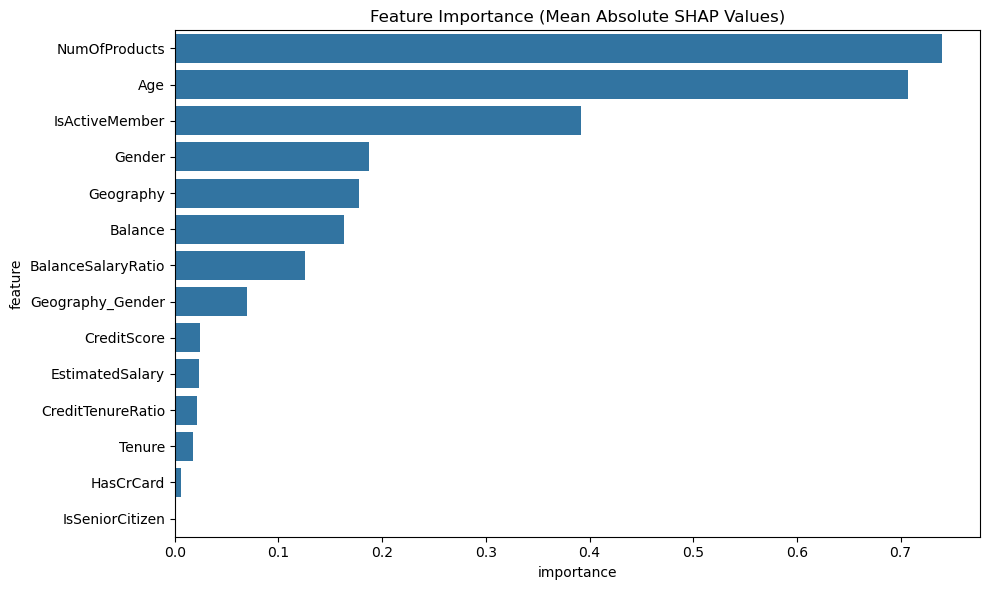

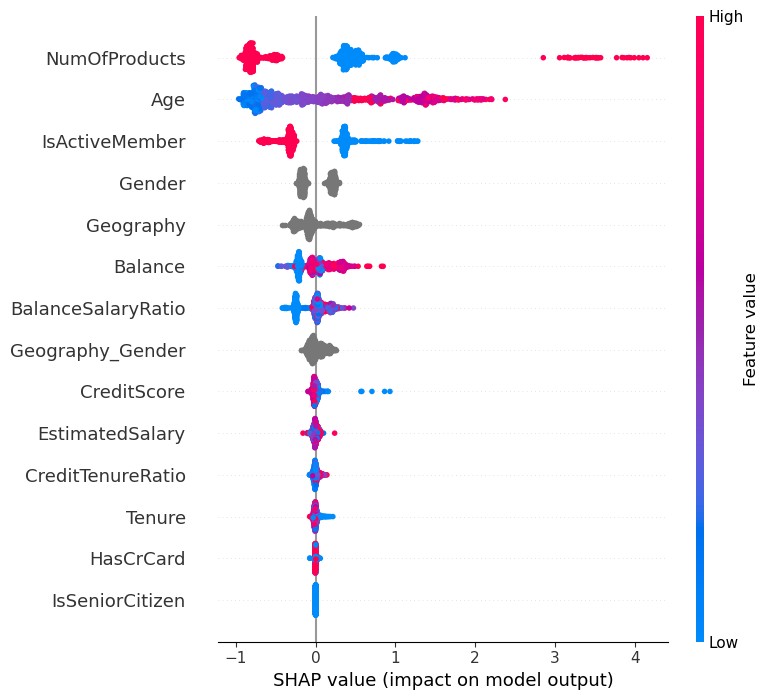

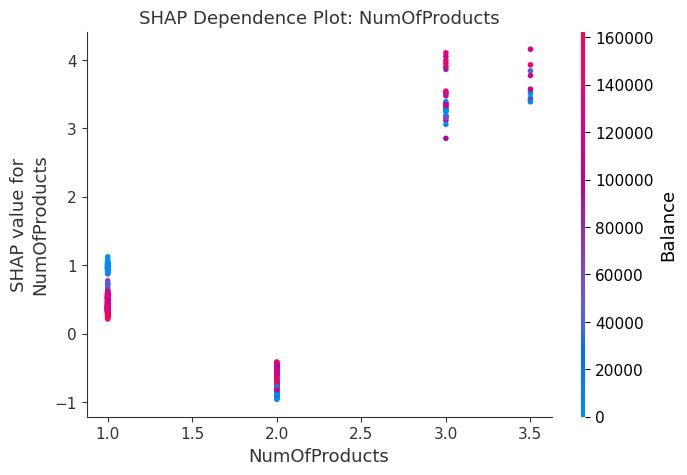

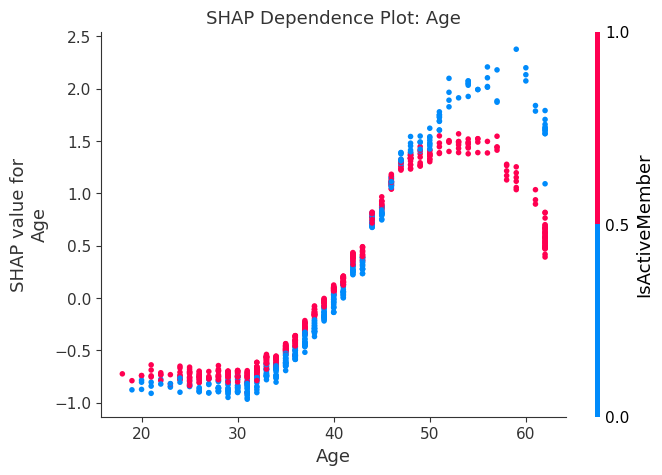

In [12]:
import shap
from shap import TreeExplainer, summary_plot
explainer = TreeExplainer(model)
x_test_sample = x_test.sample(n=1000, random_state=42)
shap_values = explainer.shap_values(x_test_sample)


# Generate SHAP summary plot (Bar graph)
# Calculate mean absolute SHAP values
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)
feature_names = x_test_sample.columns

# Create a DataFrame for plotting
shap_importance_df = pd.DataFrame({'feature': feature_names, 'importance': mean_abs_shap_values})
shap_importance_df = shap_importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=shap_importance_df)
plt.title('Feature Importance (Mean Absolute SHAP Values)')
plt.tight_layout()
plt.show()

# Generate SHAP summary plot (Dot)
summary_plot(shap_values, x_test_sample, title="SHAP Summary Plot (Dot)")

# Generate SHAP dependence plots for important features
important_features = shap_importance_df['feature'].head(2).tolist()
for feature in important_features:
    shap.dependence_plot(feature, shap_values, x_test_sample, title=f"SHAP Dependence Plot: {feature}")


### Generate and Save Churn Predictions

This cell generates a CSV file containing the churn predictions for the test set. It creates a DataFrame with the predicted churn values and includes important features from the test set. It then saves this DataFrame to a CSV file named 'churn_predictions.csv'. Finally, it calculates and prints the number and percentage of customers predicted to churn and stay.

In [13]:
# Generate a final churn prediction CSV
# Create a DataFrame with predictions
predictions_df = pd.DataFrame({'Predicted_Churn': y_pred}, index=y_test.index)

# Add important fields from the test set to the predictions DataFrame
important_fields_from_X_test = x_test[['CreditScore', 'Geography', 'Gender', 'Age',  'IsActiveMember']].copy()

# Join the important fields with the predictions DataFrame based on the index
predictions_df = predictions_df.join(important_fields_from_X_test)

# Save the DataFrame to a CSV file
predictions_df.to_csv('churn_predictions.csv', index=False) # Set index=False if you add CustomerId back and don't need the original index
print("Churn predictions saved to 'churn_predictions.csv'")

# Calculate and print the number of churned customers out of the total
churned_customers_count = predictions_df['Predicted_Churn'].sum()
total_customers = len(predictions_df)
stayed_customers_count = total_customers - churned_customers_count
stayed_percentage = (stayed_customers_count / total_customers) * 100

print(f"Percentage of customers likely to use the service (predicted to stay): {stayed_percentage:.2f}%")

print(f"Number of customers predicted to churn: {churned_customers_count} out of {total_customers}")

Churn predictions saved to 'churn_predictions.csv'
Percentage of customers likely to use the service (predicted to stay): 87.90%
Number of customers predicted to churn: 242 out of 2000
